In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
%run '../functions.ipynb'

In [2]:
#Functions to prepare the data

def create_lags(series, nlags):
    df=pd.DataFrame(series)
    for i in range(nlags):
        lag=df['lag_{}'.format(i+1)]=df.iloc[:,0].shift(i+1)
    return df.dropna()



def train_test_split(data, pct):
    size=size=int(pct*len(data))
    data_train=data.iloc[:size]
    data_test=data.iloc[size:]
    return (data_train, data_test)



def pipeline(prices, nlags, pct, classification=False):
     return train_test_split(create_lags(log_ret(prices), nlags), pct)


def Xy_split(data):
    X = data.iloc[:,1:]
    y = data.iloc[:,0]
    return X, y

We fetch our data.

In [3]:
start = '2021-01-01'
end   = '2024-01-01'
data = yf.Ticker('GOOG').history(start=start, end=end)
data.index=pd.to_datetime(data.index.date) #reindex removing hours
close=data.Close

## Classification

In [4]:
def class_strat(close, model, nlags, pct):

    train, test = pipeline(close, nlags, pct)                
    X_train, y_train = Xy_split(train)
    X_test, y_test = Xy_split(test)

    #X_train = np.sign(X_train)
    y_train = np.sign(y_train)
    #X_test=np.sign(X_test)
    y_test=np.sign(y_test)


    model.fit(X_train,y_train)

    train['pred']=model.predict(X_train)
    test['pred']=model.predict(X_test)


    hold_returns_train= np.exp( train.iloc[:,0].cumsum() )
    strat_returns_train=np.exp((train.iloc[:,0]*train.pred.shift(0)).cumsum() )
    hold_returns_test=np.exp((test.iloc[:,0]).cumsum())
    strat_returns_test=np.exp((test.iloc[:,0]*test.pred.shift(0)).cumsum())


    print('{:24}{:<25}'.format('hold returns, train', hold_returns_train[-1]))
    print('{:24}{:<25}'.format('strat returns, train', strat_returns_train[-1]))
    print('{:24}{:<25}'.format('hold returns, test', hold_returns_test[-1]))
    print('{:24}{:<25}'.format('strat returns, test', strat_returns_test[-1]))


    hold_returns_train.plot(color='blue',label='stock')
    strat_returns_train.plot(color='orange', label='strategy')
    ax=plt.gca()
    lims=ax.get_ylim()
    plt.fill_between(hold_returns_train.index, lims[0], lims[1], color='grey', alpha=0.2)
    plt.legend()
    hold_returns_test.plot(color='blue',label='stock')
    strat_returns_test.plot(color='orange',label='strategy')

Let's test the function now.

In [7]:
nlags=4
pct=0.8

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


#try the different models
logit=LogisticRegression(penalty='none')
svc=SVC()
knn=KNeighborsClassifier(n_neighbors=10)
naive=GaussianNB()

hold returns, train     1.3915232253745051       
strat returns, train    5.736899195484501        
hold returns, test      1.1333332883402554       
strat returns, test     1.1915786642808763       


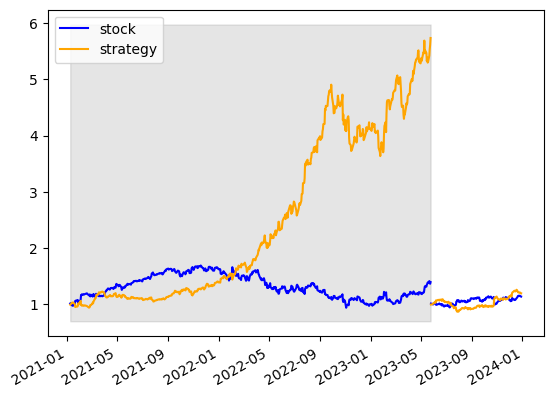

In [8]:
class_strat(close,knn,3,0.8)

In [125]:
# note: we could also use the Logistic Regression from statsmodels

#import statsmodels.api as sm
#X_new=sm.add_constant(X_train)             #we must add a constant
#y_new=y_train.replace(-1,0)                #the classes must be 0 and 1
#results=sm.Logit(y_new, X_new).fit()       #the data must be input directly into Logit with y first
#results.summary()                          #we can get a summary table with p-values
#probs=results.predict(X_new)               #predict gives the probabilities, not the classes
#y_pred=pd.Series(np.where(probs>0.5, 1, 0), index=y_new)